# Phase 3: Transformer-Based Text Classification (DistilBERT)

- Dataset: AG News
- Model: DistilBERT (distilbert-base-uncased)
- Framework: HuggingFace Transformers + PyTorch
- Hardware: CPU
- Epochs: 5

Goal:
Demonstrate state-of-the-art NLP using pretrained Transformers and fine-tuning.


In [15]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [17]:
data_path = "../data/AG_news/train.csv"

# Read CSV normally (it already has headers)
df = pd.read_csv(data_path)

# Rename columns for consistency
df = df.rename(columns={
    "Class Index": "label",
    "Title": "title",
    "Description": "description"
})

# Combine title + description
df["text"] = df["title"] + " " + df["description"]

# Convert labels from 1–4 → 0–3
df["label"] = df["label"].astype(int) - 1

# Keep only required columns
df = df[["text", "label"]]

df.head()


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [19]:
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [20]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [21]:
BATCH_SIZE = 16

train_dataset = NewsDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = NewsDataset(X_val, y_val, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4
)

model.to(device)  # move model to GPU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [25]:
EPOCHS = 5
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)


In [26]:
from tqdm import tqdm  # nice progress bar

In [27]:

loss_history = []

# Optional: clear GPU cache before training
torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    # tqdm for nice progress bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        # Move inputs and labels to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)  # average loss per batch
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {avg_loss:.4f}")

Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████| 6000/6000 [28:27<00:00,  3.51it/s]


Epoch 1/5 - Avg Loss: 0.2245


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████| 6000/6000 [41:27<00:00,  2.41it/s]


Epoch 2/5 - Avg Loss: 0.1342


Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████| 6000/6000 [19:48<00:00,  5.05it/s]


Epoch 3/5 - Avg Loss: 0.0903


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████| 6000/6000 [20:00<00:00,  5.00it/s]


Epoch 4/5 - Avg Loss: 0.0583


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████| 6000/6000 [20:01<00:00,  5.00it/s]

Epoch 5/5 - Avg Loss: 0.0401


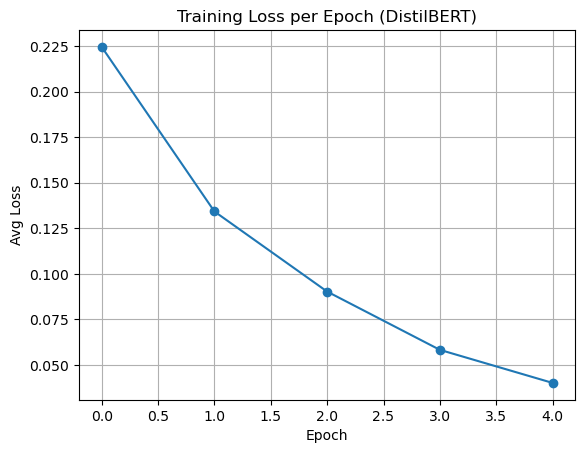

In [29]:
import matplotlib.pyplot as plt

plt.plot(loss_history, marker='o')
plt.title("Training Loss per Epoch (DistilBERT)")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.grid(True)

# Save the figure to a file
plt.savefig("../results/distilbert_training_loss.png", dpi=300, bbox_inches='tight')  # high-res PNG

# Show the plot
plt.show()
